In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
%matplotlib inline

from bs4 import BeautifulSoup

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

from dateutil import parser


# Loading Glassdoor Data

In [10]:
# load Glassdoor Data
dta = pd.read_csv("main_df_Aug1.csv")
dta = dta.drop('Unnamed: 0', 1)
dta = dta.drop_duplicates()


In [11]:
#dta.columns

In [12]:
#plt.hist(list(dta['overallRating']))

# Load Crunchbase Data

In [13]:
cb_df = pd.read_csv("/Users/deepakgautam/octo-parakeet/Crunchbase/companies.csv")

In [14]:
cName_df = pd.DataFrame()
cbUSA_df = cb_df[cb_df['country_code']=='USA']

In [20]:
# creating complete category List. Single company has multiple category 
category_list = []
for item in cbUSA_df['category_list'].str.split("|").values:
    if type(item) == list:
        category_list.extend(item)



In [21]:
# getting category with their counts
from collections import Counter
category_list = Counter(category_list)

In [17]:
# getting top 100 category to use as dummy variable
top_100_categories = category_list.most_common(100)
top_100_category_keys = dict(top_100_categories).keys()

In [22]:
def split_categories(row, top_categories):
    if type(row["category_list"]) == str:
        row_categories = row["category_list"].split("|")
        for category in row_categories:
            if category in top_categories:
                row[category] = 1
            
    return row

# Creating new dataframe with category dummy variables
cbUSA_dfWDummy = cbUSA_df.apply(split_categories, axis=1, top_categories=top_100_category_keys)



In [23]:
# Setting all NaN values in category dummy variables to 0 
for items in top_100_category_keys:
    cbUSA_dfWDummy[items] = cbUSA_dfWDummy[items].fillna(0)


In [25]:
# getting Distinct comapny with their average ratings from GlassDoor dataframe

q = "select name, avg(overallRating) as overallRating, \
avg(compensationAndBenefitsRating) as compensationAndBenefitsRating,\
avg(careerOpportunitiesRating) as careerOpportunitiesRating, avg(recommendToFriendRating) as recommendToFriendRating, \
avg(cultureAndValuesRating) as cultureAndValuesRating, avg(workLifeBalanceRating) as workLifeBalanceRating, \
avg(seniorLeadershipRating) as seniorLeadershipRating, avg(numberOfRatings) as numberOfRatings, \
avg(ceonumratings) as ceonumratings, avg(ceopctapprove) as ceopctapprove from dta  \
group by name"

distinct_glassdoorDf = pysqldf(q)


In [29]:
# Getting median glassdoor ratings 

ovllRatingMedian = distinct_glassdoorDf['overallRating'].median()
compBenRatingMedian = distinct_glassdoorDf['compensationAndBenefitsRating'].median()
carOppRatingMedian = distinct_glassdoorDf['careerOpportunitiesRating'].median()
recFriendRatingMedian = distinct_glassdoorDf['recommendToFriendRating'].median()
culValRatingMedian = distinct_glassdoorDf['cultureAndValuesRating'].median()
wLifeBalRatingMedian = distinct_glassdoorDf['workLifeBalanceRating'].median()
sLeaderRatingMedian = distinct_glassdoorDf['seniorLeadershipRating'].median()
numRatingMedian = distinct_glassdoorDf['numberOfRatings'].median()
ceoNumRatingMedian = distinct_glassdoorDf['ceonumratings'].median()
ceoApprovalPctMedian = distinct_glassdoorDf['ceopctapprove'].median()



In [30]:
#cbUSA_dfWDummy.columns
#cbUSA_df.columns

In [33]:
# Setting up final table to send to classification models
modelCB_df = cbUSA_dfWDummy

# dropping irrelevent columns
modelCB_df = modelCB_df.drop('permalink', 1)
modelCB_df = modelCB_df.drop('homepage_url', 1)
modelCB_df = modelCB_df.drop('category_list', 1)
modelCB_df = modelCB_df.drop('country_code', 1)
modelCB_df = modelCB_df.drop('state_code', 1)
modelCB_df = modelCB_df.drop('region', 1)
modelCB_df = modelCB_df.drop('city', 1)

# cleaning total funding column
modelCB_df['funding_total_usd'] = pd.to_numeric(modelCB_df['funding_total_usd'],errors='coerce')

# generating status id = 0 if company is closed , 1 otherwise 
modelCB_df['statusID'] = np.where(modelCB_df['status']=='closed', 0, 1)

#changing columns to date time and creating new columns with date diff
modelCB_df['founded_at'] = pd.to_datetime(modelCB_df['founded_at'], format="%Y-%m-%d", errors='coerce')
modelCB_df['first_funding_at'] = pd.to_datetime(modelCB_df['first_funding_at'], format="%Y-%m-%d", errors='coerce')
modelCB_df['last_funding_at'] = pd.to_datetime(modelCB_df['last_funding_at'], format="%Y-%m-%d", errors='coerce')
modelCB_df['daysToFirstFunding'] = (modelCB_df['founded_at'] - modelCB_df['first_funding_at'])/ np.timedelta64(-1, 'D')
modelCB_df['daysBetweenFirstLastFunding'] = (modelCB_df['first_funding_at'] - modelCB_df['last_funding_at'])/ np.timedelta64(-1, 'D')

# Apply median days  First Funding and Days Between to NaN values
firstFundingMedian = modelCB_df['daysToFirstFunding'].median()
lastFundingMedian = modelCB_df['daysBetweenFirstLastFunding'].median()
modelCB_df['daysToFirstFunding'] = modelCB_df['daysToFirstFunding'].fillna(firstFundingMedian)
modelCB_df['daysBetweenFirstLastFunding'] = modelCB_df['daysBetweenFirstLastFunding'].fillna(lastFundingMedian)



# Drop status, founded_at, first_funding_at, last_funding_at
modelCB_df = modelCB_df.drop('status', 1)
modelCB_df = modelCB_df.drop('founded_at', 1)
modelCB_df = modelCB_df.drop('first_funding_at', 1)
modelCB_df = modelCB_df.drop('last_funding_at', 1)


In [32]:
# joining with glassdoor data
q = 'select * from modelCB_df left join distinct_glassdoorDf on modelCB_df.name = distinct_glassdoorDf.name'
finalTable = pysqldf(q)

#drop name from final table
finalTable = finalTable.drop('name',1)


In [35]:
# fill Glassdoor na values with median ratings
finalTable['overallRating'] = finalTable['overallRating'].fillna(ovllRatingMedian) 
finalTable['compensationAndBenefitsRating'] = finalTable['compensationAndBenefitsRating'].fillna(compBenRatingMedian) 
finalTable['careerOpportunitiesRating'] = finalTable['careerOpportunitiesRating'].fillna(carOppRatingMedian)  
finalTable['recommendToFriendRating'] = finalTable['recommendToFriendRating'].fillna(recFriendRatingMedian) 
finalTable['cultureAndValuesRating'] = finalTable['cultureAndValuesRating'].fillna(culValRatingMedian) 
finalTable['workLifeBalanceRating'] = finalTable['workLifeBalanceRating'].fillna(wLifeBalRatingMedian)  
finalTable['seniorLeadershipRating'] = finalTable['seniorLeadershipRating'].fillna(sLeaderRatingMedian)  
finalTable['numberOfRatings'] = finalTable['numberOfRatings'].fillna(numRatingMedian)  
finalTable['ceonumratings'] = finalTable['ceonumratings'].fillna(ceoNumRatingMedian)  
finalTable['ceopctapprove'] = finalTable['ceopctapprove'].fillna(ceoApprovalPctMedian)  

# Classification Models

In [36]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline

In [37]:
## Here are the precision-recall curve and log-likelihood computation functions

import numpy as np
import matplotlib.pyplot as plt


def pr_curve(truthvec, scorevec, digit_prec=2):
    threshvec = np.unique(np.round(scorevec,digit_prec))
    numthresh = len(threshvec)
    tpvec = np.zeros(numthresh)
    fpvec = np.zeros(numthresh)
    fnvec = np.zeros(numthresh)

    for i in range(numthresh):
        thresh = threshvec[i]
        tpvec[i] = sum(truthvec[scorevec>=thresh])
        fpvec[i] = sum(1-truthvec[scorevec>=thresh])
        fnvec[i] = sum(truthvec[scorevec<thresh])
    recallvec = tpvec/(tpvec + fnvec)
    precisionvec = tpvec/(tpvec + fpvec)
    plt.plot(precisionvec,recallvec)
    plt.axis([0, 1, 0, 1])
    return (recallvec, precisionvec, threshvec)

def log_lik_binary(truthvec, probvec):
    return np.sum((np.log(probvec)*truthvec) + (np.log(1-probvec)*(1-truthvec)))

### Test Train Split

In [38]:
L = finalTable.dropna()
X = L.drop('statusID',1)
y = L['statusID']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression

In [47]:
#Logistic Regression
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
pred_vals_lr = model_lr.predict_proba(X_test)

In [48]:
log_lik_binary(y_test,pred_vals_lr[:,1])

-2591.38330100819

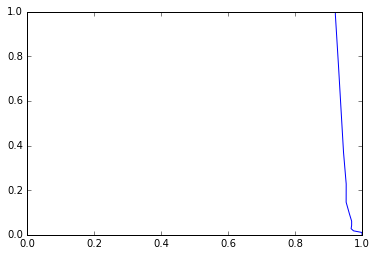

In [49]:
pr_curve(y_test,pred_vals_lr[:,1]);

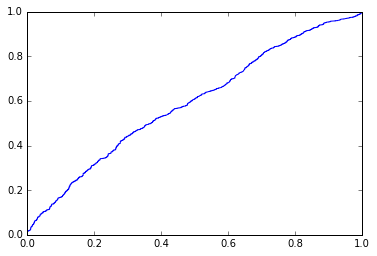

In [51]:
fpr, tpr, thresholds = roc_curve(y_test,pred_vals_lr[:,1])
plt.plot(fpr, tpr)

In [52]:
roc_auc_score(y_test,pred_vals_lr[:,1])

0.58970786898919325